# TECS ML rotation: What causes a molecule to be lipophilic and how can we predict it?

Lipophilicity is an important feature of drug molecules that affects both membrane permeability and solubility. The lipophilicity dataset, curated from ChEMBL database, provides experimental results of octanol/water distribution coefficient (logD at pH 7.4) of 4200 compounds.
See:
https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#lipo-datasets
And references in there.

**Aims:**
1.	Have a look at the dataset, are there any patterns to it?
2.	What sort of chemical features are associated with lipophilicity?
3.	Train a series of models to predict toxicity, can you beat the state of the art?

References:
1. https://moleculenet.org/ website and paper on the datasets
2. https://deepchem.readthedocs.io/en/latest/index.html manual
3. https://deepchem.readthedocs.io/en/latest/index.html tutorials


In [1]:
# lets load our libraries
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
import tensorflow as tf

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

# Loading the dataset example

In [2]:
# this line loads the  dataset - we are using the extended connectivity fingerprints here, 
# there are several featurizers for you to try
# the splitter splits the dataset for you, refer to the MoleculeNet paper to see which one you need
tasks, datasets, transformers = dc.molnet.load_lipo(
    featurizer='ECFP', 
    splitter='random')
# the datasets object is already split into the train, validation and test dataset 
train_dataset, valid_dataset, test_dataset = datasets

In [3]:
# Dataset contains the input fingerprints as X, the output lipophilicity is stored in y, and the IDS are the smiles strings
print(test_dataset)

<DiskDataset X.shape: (420, 1024), y.shape: (420, 1), w.shape: (420, 1), ids: ['COc1ccc(cc1)C(=O)C2CCN(CC2)C(=O)c3ccc(F)cc3'
 'COc1ccc(cc1CO)c2ccc3c(nc(nc3n2)N4C[C@@H](C)O[C@@H](C)C4)N5CCOCC5'
 'Cc1nc(C)c(nc1C(=O)N)c2ccc3c(CC[C@@]34CC[C@@H](CC4)C(=O)O)c2' ...
 'OCC(=O)N1CCC[C@@H]1COc2cccc3ncnc(Nc4ccc(OCc5ccccn5)c(Cl)c4)c23'
 'CC(=O)C1=C(C)c2cnc(Nc3ccc(cn3)N4CCNCC4)nc2N(C5CCCC5)C1=O'
 'CN1C(=O)N(CC2CC2)c3nn(Cc4ccnc5ccc(Cl)cc45)c(c6oc(cc6)S(=O)(=O)C)c3C1=O'], task_names: ['exp']>


# Using RDKit

RDkit is a chemistry package that allows you to create chemical features or do very simple computational chemistry.

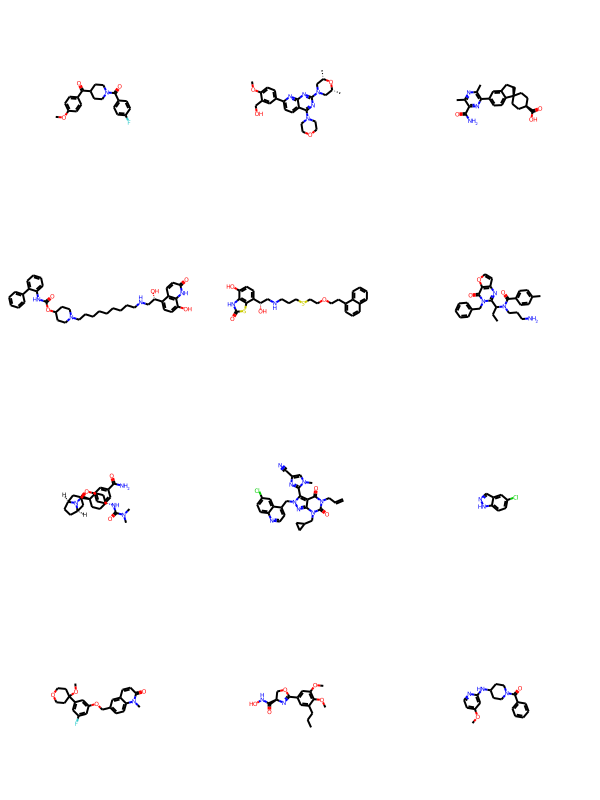

In [4]:
# and this draws a nice image of the first 12 molecules of the test_dataset
SMILES_strings = test_dataset.ids[:12]
ms = [Chem.MolFromSmiles(x) for x in SMILES_strings]
Draw.MolsToGridImage(ms)

RDKit does not give us just a picture of the molecule, it creates a molecule object:

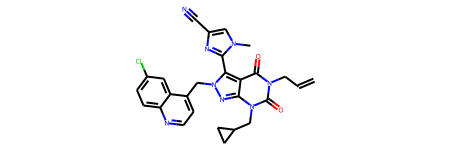

In [5]:
formula = SMILES_strings[7]
a_molecule = Chem.MolFromSmiles(formula)
a_molecule

The function `dir()` gives a list of the possible things that object can do. (Ignore those that start with ``__`` these are internal functions that you want to leave alone). For example, you could run `a_molecule.GetNumAtoms` to get the number of atoms. More details of what you can calculated with RDKit is here:
https://rdkit.org/docs/index.html

In [6]:
dir(a_molecule)

['AddConformer',
 'ClearComputedProps',
 'ClearProp',
 'Debug',
 'GetAromaticAtoms',
 'GetAtomWithIdx',
 'GetAtoms',
 'GetAtomsMatchingQuery',
 'GetBondBetweenAtoms',
 'GetBondWithIdx',
 'GetBonds',
 'GetBoolProp',
 'GetConformer',
 'GetConformers',
 'GetDoubleProp',
 'GetIntProp',
 'GetNumAtoms',
 'GetNumBonds',
 'GetNumConformers',
 'GetNumHeavyAtoms',
 'GetProp',
 'GetPropNames',
 'GetPropsAsDict',
 'GetRingInfo',
 'GetStereoGroups',
 'GetSubstructMatch',
 'GetSubstructMatches',
 'GetUnsignedProp',
 'HasProp',
 'HasSubstructMatch',
 'NeedsUpdatePropertyCache',
 'RemoveAllConformers',
 'RemoveConformer',
 'SetBoolProp',
 'SetDoubleProp',
 'SetIntProp',
 'SetProp',
 'SetUnsignedProp',
 'ToBinary',
 'UpdatePropertyCache',
 '__DebugMol',
 '__GetSubstructMatch',
 '__GetSubstructMatches',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getinitargs__',
 '__gt__',
 '__hash__',
 '__

In [7]:
# this brings up the manual for the object
help(a_molecule)

Help on Mol in module rdkit.Chem.rdchem object:

class Mol(Boost.Python.instance)
 |  The Molecule class.
 |  
 |  In addition to the expected Atoms and Bonds, molecules contain:
 |    - a collection of Atom and Bond bookmarks indexed with integers
 |        that can be used to flag and retrieve particular Atoms or Bonds
 |        using the {get|set}{Atom|Bond}Bookmark() methods.
 |  
 |    - a set of string-valued properties. These can have arbitrary string
 |        labels and can be set and retrieved using the {set|get}Prop() methods
 |        Molecular properties can be tagged as being *computed*, in which case
 |          they will be automatically cleared under certain circumstances (when the
 |          molecule itself is modified, for example).
 |        Molecules also have the concept of *private* properties, which are tagged
 |          by beginning the property name with an underscore (_).
 |  
 |  Method resolution order:
 |      Mol
 |      Boost.Python.instance
 |      bu

In [8]:
a_molecule.GetNumAtoms()

38

# More about the dataset
The input, `X`, is a fingerprint, a list of `1`s and `0`s for wether a feature is present or not (a feature like a functional group). There are other types of input that you get from other featurizers that are needed for different ML models.

The output `y` is the lipophilicity of that molecule.

In [9]:
test_dataset.X[7]

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
test_dataset.y[11]

array([-0.09768816])

 You can investigate the data, for example, below is a histogram of the values of lipophilicity in the dataset. 

(array([ 44.,  83., 136., 249., 377., 516., 653., 685., 451., 166.]),
 array([-3.0641939883892366, -2.564221095297683, -2.064248202206129,
        -1.5642753091145751, -1.0643024160230212, -0.5643295229314673,
        -0.06435662983991364, 0.4356162632516405, 0.9355891563431942,
        1.4355620494347479, 1.9355349425263022], dtype=object),
 <BarContainer object of 10 artists>)

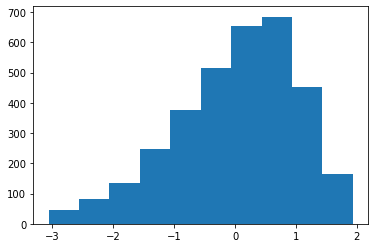

In [11]:
plt.hist(train_dataset.y)

(array([10.,  7., 12., 37., 48., 73., 69., 81., 64., 19.]),
 array([-2.922535  , -2.43672801, -1.95092101, -1.46511402, -0.97930702,
        -0.49350003, -0.00769304,  0.47811396,  0.96392095,  1.44972795,
         1.93553494]),
 <BarContainer object of 10 artists>)

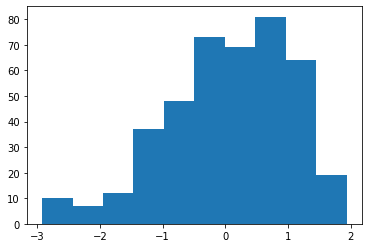

In [18]:
plt.hist(test_dataset.y)

# Machine learning example
(see also the 4th and 5th notebooks in the Machine Learning for Chemist's course).
The code below uses one of `deepchem`'s models. There are also relevant models in the `sklearn` module. There are more options that be tuned. The process of changing these options is called *hyperparameter optimisation*.

In [14]:
# this loads in a general purpose regression model
model = dc.models.MultitaskRegressor(
    n_tasks=1, # size of y, we have one output task here: finding lipophilicity
    n_features=len(test_dataset.X[0]), # number of input features, i.e. the length of the ECFPs
    dropouts=0.2)
#GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

############################################
# Now we fit the training dataset!             #
############################################
model.fit(train_dataset)

0.37863907814025877

This tests the trained model.

In [15]:
# this line tells deepchem what metric to use to score the datasets
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

# model.evaluate() tests the model. 
# we have to give it the data to use, the metric (or set of metrics) and the transformer used

print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.6930504389809332}
Test set score: {'pearson_r2_score': 0.36592993817715985}


Text(0.5, 1.0, 'Lipophilicity')

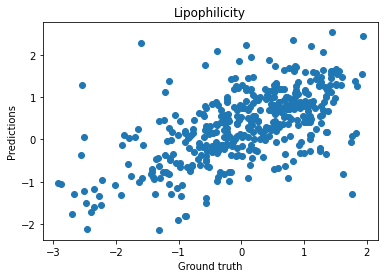

In [16]:
# Get the predictions from the model for the test dataset
predictions = model.predict_on_batch(test_dataset.X)
# Gets the correct answers (the ground truth)
ground_truth = test_dataset.y
# plots them against one another
plt.scatter(ground_truth, predictions)
plt.xlabel('Ground truth')
plt.ylabel('Predictions')
plt.title('Lipophilicity')

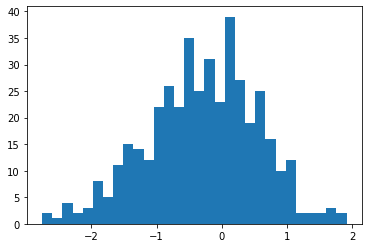

In [17]:
# this gets the errors on each point
errors = predictions - ground_truth
# this tidies it from a list of lists into a single list
errors = [x[0][0] for x in errors]
_=plt.hist(errors, bins=30)

Now go and have a play